In [4]:
pip install tensorflow


                                              0.0/284.2 MB ? eta -:--:--
                                              0.0/284.2 MB ? eta -:--:--
                                              0.1/284.2 MB 1.3 MB/s eta 0:03:36
                                              0.1/284.2 MB 1.3 MB/s eta 0:03:37
                                              0.2/284.2 MB 1.8 MB/s eta 0:02:38
                                              0.2/284.2 MB 1.8 MB/s eta 0:02:38
                                              0.4/284.2 MB 1.8 MB/s eta 0:02:41
                                              0.5/284.2 MB 2.1 MB/s eta 0:02:14
                                              0.6/284.2 MB 2.2 MB/s eta 0:02:10
                                              0.7/284.2 MB 2.2 MB/s eta 0:02:08
                                              0.9/284.2 MB 2.6 MB/s eta 0:01:50
                                              1.0/284.2 MB 2.5 MB/s eta 0:01:55
                                              1.1/284.

In [6]:
pip install keras.layers

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement keras.layers (from versions: none)
ERROR: No matching distribution found for keras.layers


In [2]:
pip install Keras

                                              0.0/1.7 MB ? eta -:--:--
                                              0.0/1.7 MB 1.3 MB/s eta 0:00:02
     --                                       0.1/1.7 MB 1.3 MB/s eta 0:00:02
     --                                       0.1/1.7 MB 1.2 MB/s eta 0:00:02
     -----                                    0.2/1.7 MB 1.6 MB/s eta 0:00:01
     ---------                                0.4/1.7 MB 2.3 MB/s eta 0:00:01
     --------------                           0.6/1.7 MB 2.8 MB/s eta 0:00:01
     ----------------                         0.7/1.7 MB 2.7 MB/s eta 0:00:01
     --------------------                     0.9/1.7 MB 3.0 MB/s eta 0:00:01
     -----------------------                  1.0/1.7 MB 3.2 MB/s eta 0:00:01
     -------------------------                1.1/1.7 MB 3.0 MB/s eta 0:00:01
     ------------------------------           1.3/1.7 MB 3.3 MB/s eta 0:00:01
     -----------------------------------      1.5/1.7 MB 3.4 MB/s eta 0

In [7]:
pip install Keras

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
# from tqdm import tqdm_notebook as tqdm #to check loop progress
from tqdm.notebook import tqdm
tqdm().pandas()
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

0it [00:00, ?it/s]

In [2]:
def load_fp(filename):
  # Open file to read
# To load the document file and read the contents of the file into a string.
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
def img_capt(filename): 
#     To create a description dictionary that will map images with all 5 captions.
    file = load_fp(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [4]:
onlycaptions=[]
def txt_clean(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            descp = img_caption.split()
            #uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            #remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            #remove hanging 's and a
            descp = [wrd for wrd in descp if(len(wrd)>1)]
            #remove words containing numbers with them
            descp = [wrd for wrd in descp if(wrd.isalpha())]
            #converting back to string
            img_caption = ' '.join(descp)
            captions[img][i]= img_caption
    return captions

In [5]:
def txt_vocab(descriptions):
  # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


In [6]:
#To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)  # Use '\t' instead of 't' for tab separation
    data = "\n".join(lines)  # Use '\n' instead of 'n' for newline separation
    with open(filename, "w") as file:
        file.write(data)

#  Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
dataset_text = "D:shikhaProject - Image Caption GeneratorFlickr_8k_text"

#to prepare our text data
# filename = dataset_text + "/" + "Flickr8k.token.txt"
filename= "C:/Users/fatim/My first Folder/Flickr8k_text/Flickr8k.token.txt"
print(filename)
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")

C:/Users/fatim/My first Folder/Flickr8k_text/Flickr8k.token.txt
Length of descriptions = 8092
Length of vocabulary =  8763


In [20]:
def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    
    for pic in tqdm(os.listdir(directory)):
        file = os.path.join(directory, pic)
        image = Image.open(file)
        image = image.resize((299, 299))
        image = np.expand_dims(image, axis=0)
        image = image / 127.5
        image = image - 1.0
        feature = model.predict(image)
        features[pic] = feature
    
    return features

In [26]:
dataset_images = "C:/Users/fatim/My first Folder/Flickr8k_Dataset/Flicker8k_Dataset"
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))
#to directly load the features from the pickle file.
features = load(open("features.p","rb"))

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 1s 685ms/step


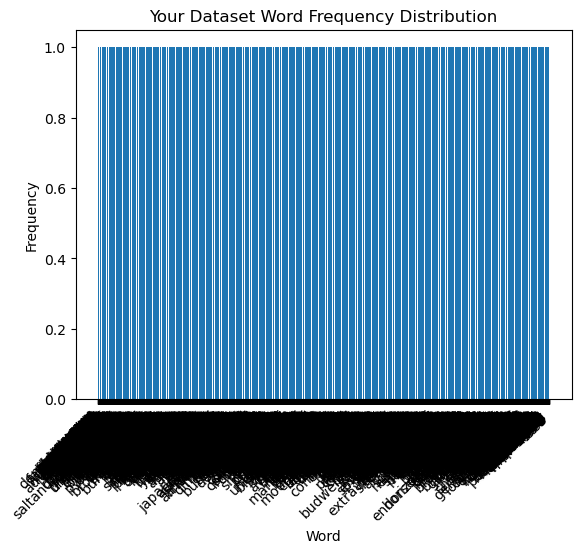

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Load the vocabulary

# Count the frequency of each word
word_counts = Counter(vocabulary)

# Get the most common words
most_common_words = word_counts.most_common()

# Extract the words and their frequencies
words = [word[0] for word in most_common_words]
frequencies = [word[1] for word in most_common_words]

# Ensure that plots are displayed inline in the Jupyter Notebook
%matplotlib inline

# Create the word frequency distribution plot
plt.bar(words, frequencies)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Your Dataset Word Frequency Distribution")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()


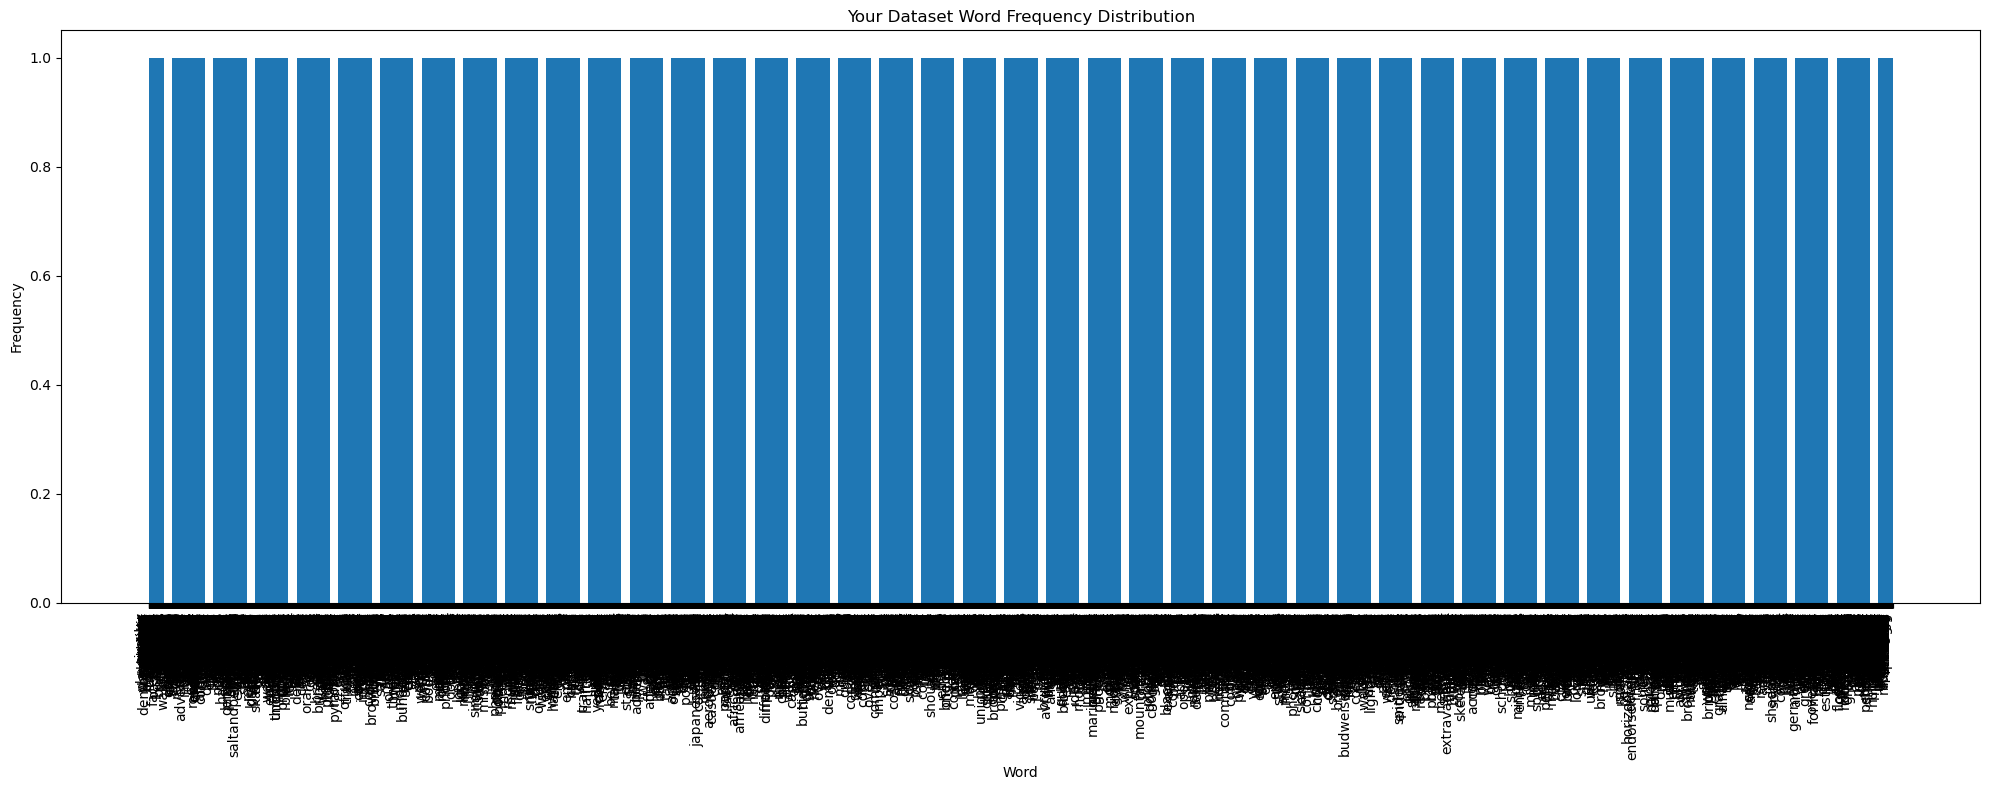

In [18]:
# Ensure that plots are displayed inline in the Jupyter Notebook
%matplotlib inline

# Increase the figure size for better readability
plt.figure(figsize=(20, 8))

# Create the word frequency distribution plot
plt.bar(words, frequencies, width=0.8)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Your Dataset Word Frequency Distribution")
# plt.xticks(  np.arange(0,1600,100), rotation=45)  # Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha="right")
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [19]:
top_frequencies = [word[1] for word in most_common_words[:10]]
print(top_frequencies)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [30]:
import string
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Load captions from file
def load_captions(file_path):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    return captions

# Tokenize and clean captions
def tokenize_and_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    stop_words = set(stopwords.words('english'))
    
    all_words = []
    for caption in captions:
        # Tokenize the caption into words
        words = word_tokenize(caption.lower())
        
        # Remove punctuation and stop words
        words = [word.translate(table) for word in words if word.isalpha() and word not in stop_words]
        
        all_words.extend(words)
    
    return all_words

# Count word frequencies
def count_word_frequencies(words):
    word_counts = Counter(words)
    return word_counts

# File path to the Flickr8k.token.txt or your caption file
file_path = "C:/Users/fatim/My first Folder/Flickr8k_text/Flickr8k.token.txt"

# Load captions
captions = load_captions(file_path)

# Tokenize and clean captions
all_words = tokenize_and_clean(captions)

# Count word frequencies
word_frequencies = count_word_frequencies(all_words)

# Display the top 10 words and their frequencies
top_words = word_frequencies.most_common(10)
print("Top 10 words and their frequencies:")
for word, frequency in top_words:
    print(f"{word}: {frequency}")


Top 10 words and their frequencies:
dog: 8136
man: 7266
two: 5639
white: 3940
black: 3832
boy: 3581
woman: 3403
girl: 3328
wearing: 3062
people: 2887


In [27]:
import nltk

# Download the stopwords resource
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fatim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

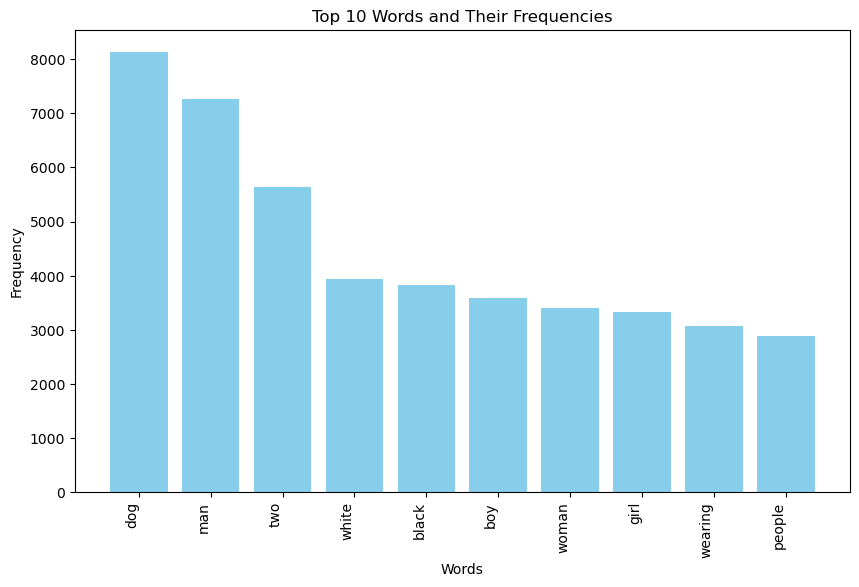

In [34]:
# Plot the bar chart

words = [word[0] for word in top_words]
frequencies = [word[1] for word in top_words]
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words and Their Frequencies')
plt.xticks(rotation=90, ha='right')
plt.show()

Average Caption Length: 6.18 words
Maximum Caption Length: 20 words
Minimum Caption Length: 0 words


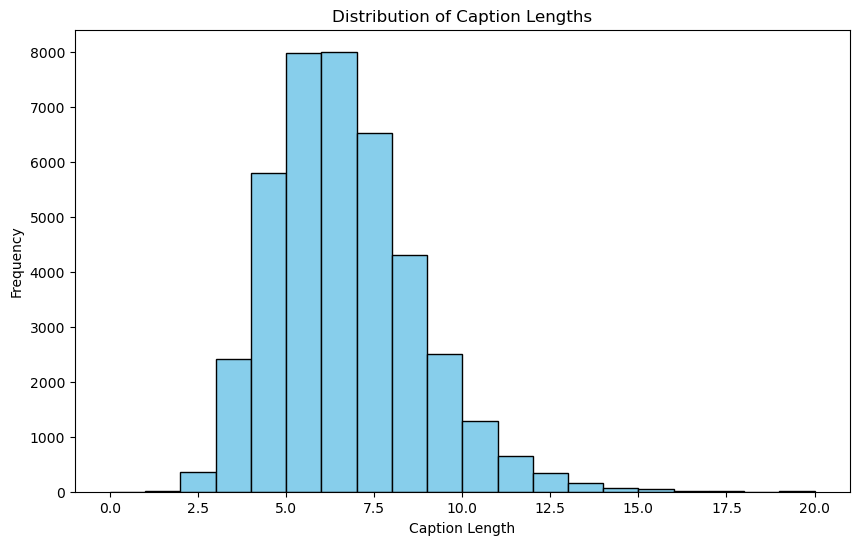

In [38]:


# Load captions from file
def load_captions(file_path):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    return captions

# Tokenize and clean captions
def tokenize_and_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    stop_words = set(stopwords.words('english'))
    
    all_words = []
    caption_lengths = []
    for caption in captions:
        # Tokenize the caption into words
        words = word_tokenize(caption.lower())
        
        # Remove punctuation and stop words
        words = [word.translate(table) for word in words if word.isalpha() and word not in stop_words]
        
        all_words.extend(words)
        
        # Calculate the length of the caption
        caption_length = len(words)
        caption_lengths.append(caption_length)
    
    return all_words, caption_lengths

# File path to the Flickr8k.token.txt or your caption file
file_path = "C:/Users/fatim/My first Folder/Flickr8k_text/Flickr8k.token.txt"

# Load captions
captions = load_captions(file_path)

# Tokenize and clean captions, and get caption lengths
all_words, caption_lengths = tokenize_and_clean(captions)


#  Calculate average, maximum, and minimum caption lengths
avg_length = sum(caption_lengths) / len(caption_lengths)
max_length = max(caption_lengths)
min_length = min(caption_lengths)

# Print the results
print(f"Average Caption Length: {avg_length:.2f} words")
print(f"Maximum Caption Length: {max_length} words")
print(f"Minimum Caption Length: {min_length} words")


# Plot the histogram of caption lengths
plt.figure(figsize=(10, 6))
plt.hist(caption_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.show()


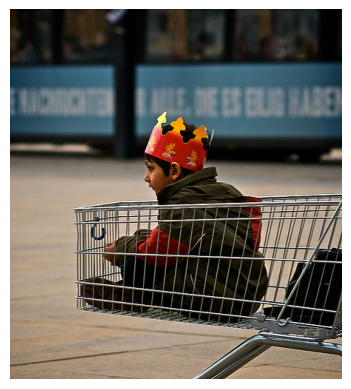

Caption: 1355703632_5683a4b6fb.jpg#0	A female softball player making a pitch .




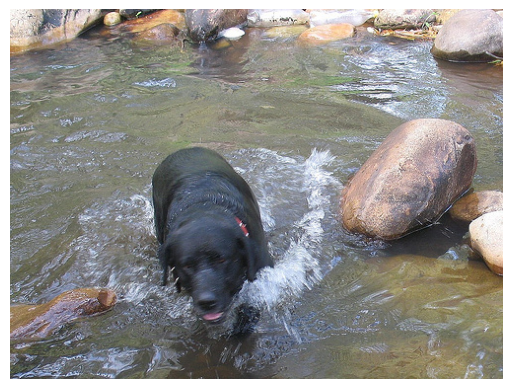

Caption: 1332208215_fa824f6659.jpg#2	People sit inside a train .




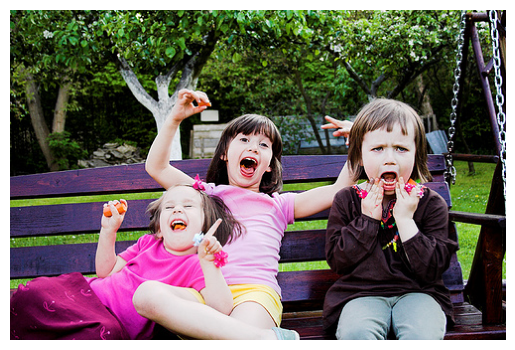

Caption: 1417031097_ab656bc4bd.jpg#3	People on an amusement park ride .




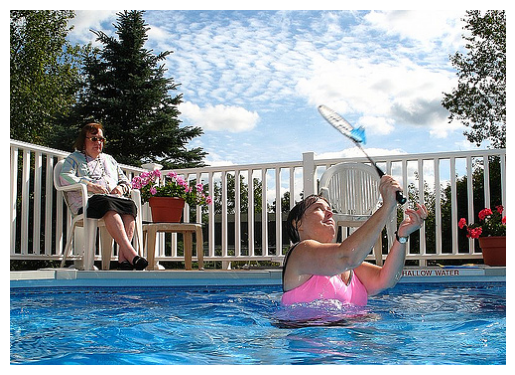

Caption: 1810651611_35aae644fb.jpg#1	A little girl in a dress with pink flowers swings on a red-seated swing .




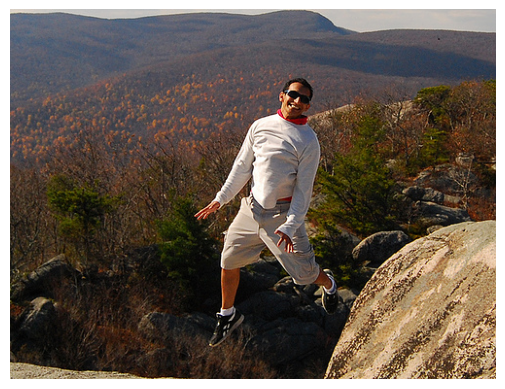

Caption: 1813266419_08bf66fe98.jpg#2	A girl playing in a fountain




In [42]:
import os
import random


# Function to load image paths
def load_image_paths(directory):
    return [os.path.join(directory, filename) for filename in os.listdir(directory)]

# Function to display image-caption pairs
def display_image_caption_pairs(image_paths, captions, num_pairs=5):
    # Randomly select image-caption pairs
    selected_pairs = random.sample(list(zip(image_paths, captions)), num_pairs)

    # Display each pair
    for image_path, caption in selected_pairs:
        # Load and display the image
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

        # Print the associated caption
        print(f"Caption: {caption}\n")

# Directory containing images (adjust the path accordingly)
image_directory = "C:/Users/fatim/My first Folder/Flickr8k_Dataset/Flicker8k_Dataset"

# Load image paths and captions
image_paths = load_image_paths(image_directory)
file_path = "C:/Users/fatim/My first Folder/Flickr8k_text/Flickr8k.token.txt"

# Load captions
captions = load_captions(file_path)

# Display image-caption pairs
display_image_caption_pairs(image_paths, captions)
